In [1]:
import os;
import matplotlib_inline.backend_inline as mibi;
mibi.set_matplotlib_formats("svg","pdf");
import matplotlib.pyplot as plt;
import seaborn as sns;
import tqdm as tqdm;

from torch.utils.data import Dataset;
import torch;
import torch.nn.functional as F;
import torch.nn as nn;
from lightly.data import LightlyDataset;
from torch.utils.data import DataLoader;
import torchvision.transforms as transforms
import torchvision;
from PIL import Image;
import numpy as np;
from tqdm import tqdm
import sys;

sns.reset_orig();
%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
fig_size = 128

transform_test = transforms.Compose([
    transforms.Resize((fig_size, fig_size)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
]);


data_path = "../datasets/celeba/";
datasets = LightlyDataset(input_dir=os.path.join(data_path,"train"),transform=transform_test);
data_loader = DataLoader(datasets,batch_size=24,shuffle=True);

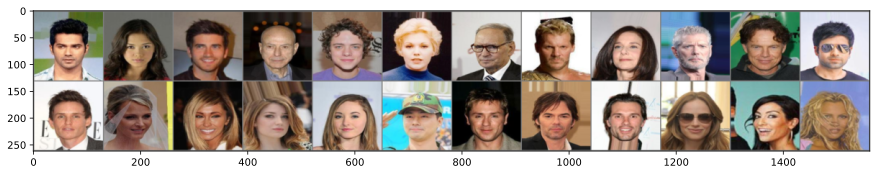

In [13]:
x,label,fnames = next(iter(data_loader));
grid = torchvision.utils.make_grid(x,nrow=12);
grid = (grid*0.5 + 0.5).permute(1,2,0)
plt.figure(figsize=(15,8))
plt.imshow(grid.numpy());

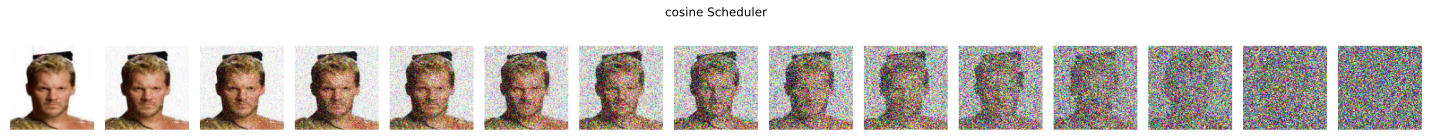

In [14]:
from clone_models.scheduler import NoiseScheduler;
from clone_utils.utils import unnormalize_to_zero_to_one;

scheduler = NoiseScheduler(1000,mode = "cosine");
#scheduler = NoiseScheduler(1000,mode = "linear");

sample_image = x[7].unsqueeze(0);
fig_cos, axs_cos = plt.subplots(ncols=15, figsize=(20, 2));

T = scheduler.T;
for idx, t in enumerate(np.linspace(0, T-1, 15, dtype=int)):
    t = torch.tensor(t,device=sample_image.device);
    #zero_noise = torch.zeros_like(sample_image);
    noisy_image = scheduler.sample_marginal_prob(sample_image,t);
    noisy_image = unnormalize_to_zero_to_one(noisy_image).clamp(0,1).squeeze();
    noisy_image = noisy_image.permute(1,2,0).detach().cpu().numpy(); #[C,H,W]->[H,W,C]
    axs_cos[idx].imshow(noisy_image)
    axs_cos[idx].set_axis_off();
fig_cos.suptitle(f"{scheduler.mode} Scheduler");
fig_cos.tight_layout()

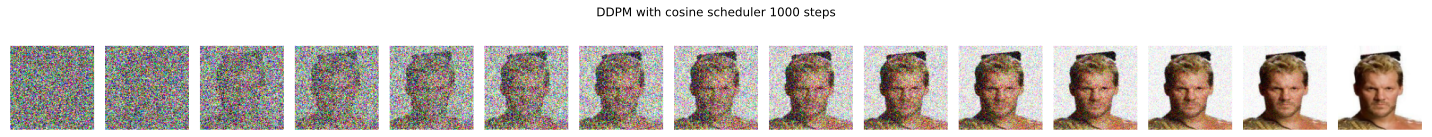

In [15]:
from clone_models.DDPM import DDPM;

fig, axs = plt.subplots(ncols=15, figsize=(20, 2))
t = torch.tensor([t], device=x.device)

pred_gt = lambda x_t, t, context: sample_image
sampler = DDPM(pred_gt, scheduler)
x_T = scheduler.prior_sampling((fig_size,fig_size))
noisy_image = sampler.sampling(x_T, return_all=True, context=torch.zeros(x_T.shape[0]))
perturbed_data = unnormalize_to_zero_to_one(noisy_image).clamp(0, 1)
for idx, t_ in enumerate(np.linspace(0, T, 15, dtype=int)):
    x_t = torch.squeeze(perturbed_data[t_]).permute(1,2,0).detach().cpu().numpy()
    axs[idx].imshow(x_t)
    axs[idx].set_axis_off()

fig.suptitle(f"DDPM with {scheduler.mode} scheduler {scheduler.T} steps")
fig.tight_layout();
plt.show();

In [456]:
from clone_models.Unet import Unet;
from torchinfo import summary;

unet = Unet(dim=64,out_dim=3,dim_mults=(1,2,2,4));

summary(unet,input_size=[(8,3,256,256),(8,),(9,8,32,64,64),(8,3,256,256)],
        dtypes = [torch.float,torch.long,torch.float,torch.float],
        depth=1)

Layer (type:depth-idx)                                  Output Shape              Param #
Unet                                                    [8, 3, 256, 256]          --
├─SinusoidalPosEmb: 1-1                                 [8, 64]                   --
├─Sequential: 1-2                                       [8, 64]                   33,088
├─ConvTranspose2d: 1-3                                  [8, 64, 256, 256]         393,280
├─ModuleList: 1-4                                       --                        3,733,504
├─ResnetBlock: 1-5                                      [8, 256, 32, 32]          1,196,800
├─Residual: 1-6                                         [8, 256, 32, 32]          131,329
├─ResnetBlock: 1-7                                      [8, 256, 32, 32]          1,196,800
├─ModuleList: 1-8                                       --                        2,775,552
├─Sequential: 1-9                                       [8, 3, 256, 256]          37,123
Total params: 

In [457]:
from clone_models.LR_encoder import RRDBNet;
rrdb = RRDBNet();

summary(rrdb,input_size=[(8,3,64,64)],dtypes=[torch.float])

Layer (type:depth-idx)                        Output Shape              Param #
RRDBNet                                       [8, 3, 256, 256]          --
├─Conv2d: 1-1                                 [8, 32, 64, 64]           896
├─ModuleList: 1-2                             --                        --
│    └─RRDB: 2-1                              [8, 32, 64, 64]           --
│    │    └─ResidualDenseBlock_5C: 3-1        [8, 32, 64, 64]           138,400
│    │    └─ResidualDenseBlock_5C: 3-2        [8, 32, 64, 64]           138,400
│    │    └─ResidualDenseBlock_5C: 3-3        [8, 32, 64, 64]           138,400
│    └─RRDB: 2-2                              [8, 32, 64, 64]           --
│    │    └─ResidualDenseBlock_5C: 3-4        [8, 32, 64, 64]           138,400
│    │    └─ResidualDenseBlock_5C: 3-5        [8, 32, 64, 64]           138,400
│    │    └─ResidualDenseBlock_5C: 3-6        [8, 32, 64, 64]           138,400
│    └─RRDB: 2-3                              [8, 32, 64, 64]   

In [458]:
class CustomDataset(Dataset):
    def __init__(self, input_dir, transform_highres=None, transform_lowres=None):

        self.input_dir = input_dir
        self.transform_highres = transform_highres
        self.transform_lowres = transform_lowres
        self.image_filenames = [f for f in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, f))]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.input_dir, self.image_filenames[idx])
        image = Image.open(img_name).convert('RGB')

        seed = np.random.randint(low=0,high=2**31,size=1);
        torch.manual_seed(seed);
        np.random.seed(seed);
        
        if self.transform_highres:
            high_res_image = self.transform_highres(image)
        if self.transform_lowres:
            low_res_image = self.transform_lowres(image)

        img_lr_up = F.interpolate(input = low_res_image.unsqueeze(0),scale_factor=4.0,mode="bicubic")
        
        return high_res_image.squeeze(),low_res_image.squeeze(),img_lr_up.squeeze();


file_size = 256;

transform_highres = transforms.Compose([
    transforms.Resize((file_size, file_size)),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation((-45,45)),
    #transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
]);

data_path = "C:/CU/pattern/project/python/data/CUFS/gg";
transform_lowres = transforms.Compose([
    transforms.Resize((file_size//4, file_size//4)),
    #transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.GaussianBlur(kernel_size=5, sigma=0.6),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
]);

dataset = CustomDataset(input_dir=os.path.join(data_path, "train"),
                transform_highres=transform_highres,
                transform_lowres=transform_lowres)
data_loader = DataLoader(dataset, batch_size=8,shuffle=True);

In [459]:
# from clone_trainer.SRDiffTrainer import SRDiffTrainer;
# sr_trainer = SRDiffTrainer();
# sr_trainer.train()

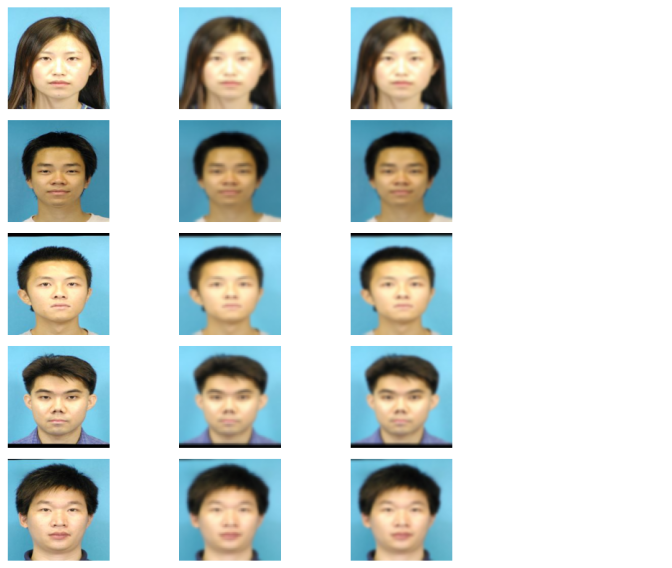

In [463]:
img_hr,img_lr,img_lr_up = next(iter(data_loader));
fig,axs = plt.subplots(5,4,figsize=(10,8));
for i in range(img_hr.shape[0]):
    axs[i,0].imshow((img_hr[i].permute(1,2,0)*0.5 + 0.5).clip(0,1));
    axs[i,1].imshow((img_lr[i].permute(1,2,0)*0.5 + 0.5).clip(0,1));
    axs[i,2].imshow((img_lr_up[i].permute(1,2,0)*0.5 + 0.5).clip(0,1));
    if(i == 4):
        break;
for ax in axs.flatten():
    ax.axis("off")
fig.tight_layout();

In [11]:
from clone_models.Diffusion import GaussianDiffusion;

unet = Unet();
rrdb = RRDBNet();
diffusion_model = GaussianDiffusion(denoise_fn=unet,rrdb_net=rrdb,
                                    timesteps = 10000,
                                    loss_type="l2",
                                    aux_l1_loss=True,
                                    aux_percep_loss=True,
                                    aux_ssim_loss=True);

c:\Users\Mores\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mores\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu");
diffusion_model = diffusion_model.to(device);
# Setup optimizer
optimizer = optim.AdamW(diffusion_model.parameters(), lr=0.0002)

if(os.path.isfile("./weights/jeng_1000.pth") is False):
    # Number of epochs
    num_epochs = 1000

    # Training loop
    for epoch in range(num_epochs):
        running_loss = 0.0;
        avg_loss = 0;
        for i, (img_hr, img_lr, img_lr_up) in enumerate(data_loader):
            img_hr, img_lr, img_lr_up = img_hr.to(device), img_lr.to(device), img_lr_up.to(device)

            optimizer.zero_grad()

            outputs, intermediates, timesteps = diffusion_model(img_hr, img_lr, img_lr_up)

            total_loss = outputs['q']  # This will be your primary diffusion loss
            avg_loss += total_loss.item();
            total_loss.backward()
            optimizer.step()

        sys.stdout.write("\r" + f"{epoch+1}/{num_epochs} : loss {avg_loss/len(data_loader)}")

    print('Finished Training')

1000/1000 : loss 0.008179148891940713Finished Training


In [13]:
weight_path = "./weights/jeng_1000.pth";
torch.save(diffusion_model.state_dict(),weight_path);

In [15]:
unet = Unet();
rrdb = RRDBNet();
diffusion_model = GaussianDiffusion(denoise_fn=unet,rrdb_net=rrdb,
                                    timesteps = 10000,
                                    loss_type="l2",
                                    aux_l1_loss=True,
                                    aux_percep_loss=True,
                                    aux_ssim_loss=True);

diffusion_model.load_state_dict(torch.load(weight_path))

<All keys matched successfully>

In [24]:
img_lr,img_lr_up = img_lr.to(device),img_lr_up.to(device)
diffusion_model.to(device);

In [27]:
# Sample high-resolution image from low-resolution input
with torch.no_grad():
    high_res_output, _ = diffusion_model.sample(img_lr=img_lr, 
                                                img_lr_up=img_lr_up,
                                                shape=img_lr_up.shape)

sampling loop time step: 100%|██████████| 10000/10000 [04:33<00:00, 36.61it/s]


In [28]:
torch.cuda.empty_cache()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


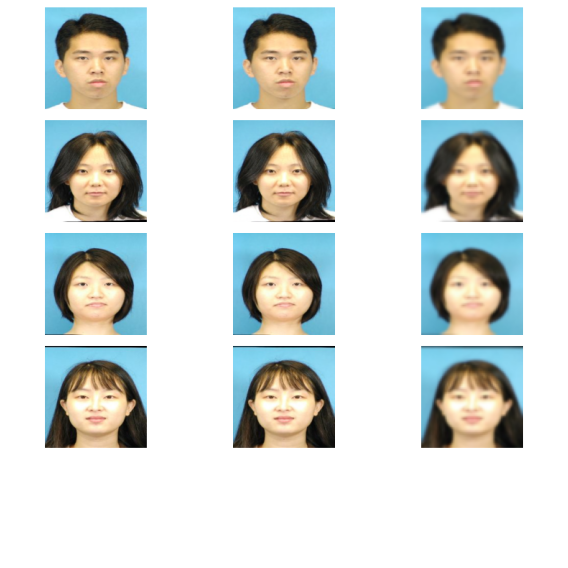

In [34]:

fig,axs = plt.subplots(5,3,figsize=(8,8));
for i in range(img_hr.shape[0]):
    axs[i,0].imshow(img_hr[i].cpu().permute(1,2,0)*0.5 + 0.5);
    axs[i,1].imshow(high_res_output[i].detach().cpu().permute(1,2,0)*0.5 + 0.5);
    axs[i,2].imshow(img_lr[i].detach().cpu().permute(1,2,0)*0.5 + 0.5);
    if(i == 4):
        break;
for ax in axs.flatten():
    ax.axis("off")
fig.tight_layout();

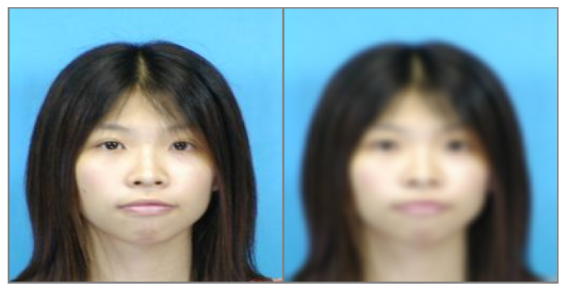

In [324]:
img_to_vis_hr,img_to_vis_lr,img_to_vis_up_lr = data_loader.dataset[0];
grid = (torchvision.utils.make_grid([img_to_vis_hr, img_to_vis_up_lr], nrow=2)*0.5 + 0.5).clamp(0,1)
grid_np = grid.permute(1, 2, 0).cpu().numpy();

# Display the grid of images
plt.figure(figsize=(10, 5))
plt.imshow(grid_np)
plt.axis('off')
plt.show()

In [325]:
img_to_vis_lr = img_to_vis_lr.to(device);
img_to_vis_up_lr = img_to_vis_up_lr.to(device);
with torch.no_grad():
    high_res_output_vis, _,res = diffusion_model.sample(img_lr=img_to_vis_lr.unsqueeze(0), 
                                                img_lr_up=img_to_vis_up_lr.unsqueeze(0),
                                                shape=img_to_vis_up_lr.unsqueeze(0).shape,
                                                save_intermediate=True)

sampling loop time step: 100%|██████████| 10000/10000 [01:16<00:00, 131.16it/s]


In [3]:
# img_to_show = torch.cat([res[i][0] for i in range(len(res)) if i%100 == 0],dim=0);
# grid = (torchvision.utils.make_grid(img_to_show,nrow=img_to_show.shape[0])*0.5 + 0.5).clamp(0,1);
# grid_np=grid.permute(1, 2, 0).cpu().numpy();
# plt.figure(figsize = (200,10))
# plt.imshow(grid_np);
# plt.tight_layout();
# plt.axis("off");

In [327]:
import matplotlib.animation as animation;
num_frames = 10000//100
frame_width = grid_np.shape[1] // num_frames

fig, ax = plt.subplots()


img_display = ax.imshow(grid_np[:, :frame_width], animated=True)
ax.axis('off');

def update(frame):
    start_x = frame * frame_width
    end_x = start_x + frame_width
    frame_img = grid_np[:, start_x:end_x]
    img_display.set_array(frame_img)
    return img_display,

ani = animation.FuncAnimation(fig, update, frames=num_frames, blit=True, interval=1)

plt.close();

ani.save('./animation_girl.gif', writer='pilow',fps=10)

MovieWriter pilow unavailable; using Pillow instead.


In [328]:
img_to_vis_hr.shape,img_to_vis_lr.shape

(torch.Size([3, 256, 256]), torch.Size([3, 64, 64]))

In [4]:
# # Convert tensors to numpy arrays for visualization

# img_hr_np = img_to_vis_hr.cpu().numpy().transpose(1, 2, 0)*0.5 + 0.5
# img_lr_np = img_to_vis_lr.cpu().numpy().transpose(1, 2, 0)*0.5 + 0.5

# fig = plt.figure(figsize=(8, 4))  # You can adjust the overall size as needed

# ax1 = fig.add_axes([0, 0, 0.8, 1])  # Left, Bottom, Width, Height (relative to figure size)
# ax1.imshow(img_hr_np)
# ax1.axis('off')

# ax2 = fig.add_axes([0.8, 0.375, 0.2, 0.25])  # The low-res image will occupy a smaller space
# ax2.imshow(img_lr_np)
# ax2.axis('off')

# plt.show()

In [5]:
# grid = (torchvision.utils.make_grid([img_to_vis_hr, high_res_output_vis.squeeze().cpu()], nrow=2)*0.5 + 0.5).clamp(0,1)
# grid_np=grid.permute(1, 2, 0).cpu().numpy();
# plt.figure(figsize = (10,10))
# plt.imshow(grid_np);
# plt.tight_layout();
# plt.axis("off");